# Metacells Vignette

This vignette demonstrates step-by-step use of the metacells package to analyze scRNA-seq data. The latest version of this vignette is available in [Github](https://github.com/tanaylab/metacells/blob/master/sphinx/Manual_Analysis.rst).

## Preparation

First, let's import the Python packages we'll be using. If you don't have these installed, run `pip install metacells`, and also `pip install seaborn` for the embedded diagrams - this is just for the purpose of this vignette; the metacells package itself has no dependency on any visualization packages.

In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import metacells as mc
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import seaborn as sb

from math import hypot
from matplotlib.collections import LineCollection
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('svg')
sb.set_style("white")

## Getting the raw data

The metacells package is built around the [scanpy](https://pypi.org/project/scanpy/) framework. In particular it uses [anndata](https://pypi.org/project/anndata/) to hold the analyzed data, and uses `.h5ad` files to persist this data on disk. You can access also these files directly from R using several packages, most notably [anndata](https://cran.r-project.org/web/packages/anndata/index.html).

You can convert data from various "standard" scRNA data formats into a `.h5ad` file using any of the functions available in the scanpy and/or anndata packages. Note that converting textual data to this format takes a "non-trivial" amount of time for large data sets. Mercifully, this is a one-time operation. Less excusable is the fact that none of the above packages memory-map the `.h5ad` files so reading large files will still take a noticeable amount of time for no good reason.

For the purposes of this vignette, we'll use a 160K cells data set which is a unification of
several batches of PBMC scRNA data from [10x](https://support.10xgenomics.com/single-cell-gene-expression/datasets>), specifically from the "Single Cell 3' Paper: Zheng et al. 2017" datasets. Since 10x do not provide stable links to their data sets, and to avoid the long time it would take to convert their textual format files to `.h5ad` files, simply download the compressed data file [pbmc163k.h5ad.gz](http://www.wisdom.weizmann.ac.il/~atanay/metac_data/pbmc163k.h5ad.gz) to your work directory (using `wget`, `curl`, your browser's download function, etc.), and then run `gunzip pbmc163k.h5ad.gz` (or your zip program of choice) to extract the `pbmc163k.h5ad` file which we read below.

The metacells package uses a convention where the `__name__` unstructured property of the data contains its name for logging purposes; we initialize this name to `PBMC` below.

In [2]:
raw = ad.read_h5ad('pbmc163k.h5ad')
mc.ut.set_name(raw, 'PBMC')
print(raw.shape)

(163234, 32738)


## Cleaning the data

The first step in processing the data is to extract a "clean" subset of it for further analysis.

If the data set contains metadata that can be used to rule out some of the genes or cells, this is a good time to do it, using the `mc.ut.slice` function.

Regardless of such metadata, we still need to perform initial filtering of the data. The exact details might vary depending on your specific data set's origins. Still, the metacells package supports a basic 2-phase procedure which should be useful in many cases.

### Cleaning the genes

The first phase excludes genes from the "clean" data.

#### Excluding genes by name

Some genes are known to be detrimental for the analysis and should be excluded from the clean data based on their name. The poster child for such genes are mitochondrial genes which we exclude using a pattern (all genes whose name starts with `MT-`).

In [3]:
excluded_gene_names = ['IGHMBP2', 'IGLL1', 'IGLL5', 'IGLON5', 'NEAT1', 'TMSB10', 'TMSB4X']
excluded_gene_patterns = ['MT-.*']

#### Excluding genes by their expression

We also want to exclude genes based on their expression. For example, it makes no sense to keep genes which have zero expression in our data set - in general we allow specifying a threshold on the minimal total UMIs of the gene in the data set. In addition, we have discovered it is useful to exclude "noisy lonely genes", that is, genes which have a significant expression level but no significant correlation with any other gene.

#### Automating clean genes selection

We provide a function that automates the above (given an explicit list of excluded gene names). All it does is create per-gene (variable) annotations in the data: `excluded_gene`, `properly_sampled_gene`, and `noisy_lonely_gene`. You can achieve the same effect by manually invoking the lower-level functions (e.g., `mc.tl.find_noisy_lonely_genes`). Or, you could create additional masks of your own based on your own criteria.

In [4]:
mc.pl.analyze_clean_genes(raw,
                          excluded_gene_names=excluded_gene_names,
                          excluded_gene_patterns=excluded_gene_patterns,
                          random_seed=123456)

set PBMC.var[properly_sampled_gene]: 22637 true (69.15%) out of 32738 bools
set PBMC.var[excluded_gene]: 20 true (0.06109%) out of 32738 bools
/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/obk/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
set PBMC.var[noisy_lonely_gene]: 0 true (0%) out of 32738 bools


We then combine all these mask into a final `clean_gene` mask. By default this is based on the three masks listed above, but you can customize it to use any list of per-gene masks instead.

In [5]:
mc.pl.pick_clean_genes(raw)

set PBMC.var[clean_gene]: 22617 true (69.08%) out of 32738 bools


This is a good time to save the data so we can load it later without recomputing it. We'll do this under a different name to avoid modifying the raw file, and we'll rename our variable refering to it for clarity.

In [6]:
raw.write('full.h5ad')
full = raw

/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


### Cleaning the cells

The second phase is excluding cells. We do so based on two criteria: the total number of UMIs we have for each cell, and the fraction of these UMIs that come from excluded (non-clean) genes.

Setting these thresholds is done manually. To guide this decision, we can visualize the relevant distributions.

#### Thresholds on the total number of UMIs

We'll start with looking at the total UMIs per cell. We set a threshold for the minimal and maximal number of UMIs of cells we wish to analyze.

Will exclude 12983 (7.95%) cells with less than 800 UMIs
Will exclude 349 (0.21%) cells with more than 8000 UMIs


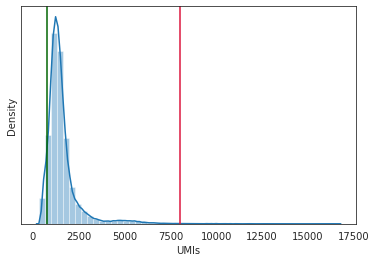

In [7]:
properly_sampled_min_cell_total = 800
properly_sampled_max_cell_total = 8000

total_umis_of_cells = mc.ut.get_o_numpy(full, name='__x__', sum=True)

plot = sb.distplot(total_umis_of_cells)
plot.set(xlabel='UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_min_cell_total, color='darkgreen')
plot.axvline(x=properly_sampled_max_cell_total, color='crimson')

too_small_cells_count = sum(total_umis_of_cells < properly_sampled_min_cell_total)
too_large_cells_count = sum(total_umis_of_cells > properly_sampled_max_cell_total)

too_small_cells_percent = 100.0 * too_small_cells_count / len(total_umis_of_cells)
too_large_cells_percent = 100.0 * too_large_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with less than %s UMIs"
      % (too_small_cells_count,
         too_small_cells_percent,
         properly_sampled_min_cell_total))
print(f"Will exclude %s (%.2f%%) cells with more than %s UMIs"
      % (too_large_cells_count,
         too_large_cells_percent,
         properly_sampled_max_cell_total))


#### Thresholds on the fractionof excluded gene UMIs

We also set a threshold on the fraction of excluded gene UMIs in each cell we wish to analyze. This ensures that there will be a sufficient number of clean gene UMIs left to analyze.

/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/obk/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Will exclude 256 (0.16%) cells with more than 10.00% excluded gene UMIs


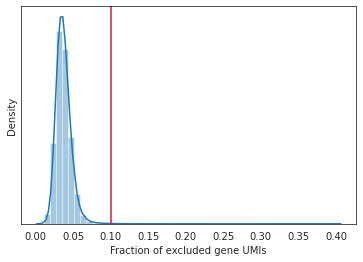

In [8]:
properly_sampled_max_excluded_genes_fraction = 0.1

excluded_genes_data = mc.tl.filter_data(full, var_masks=['~clean_gene'])[0]
excluded_umis_of_cells = mc.ut.get_o_numpy(excluded_genes_data, name='__x__', sum=True)
excluded_fraction_of_umis_of_cells = excluded_umis_of_cells / total_umis_of_cells

plot = sb.distplot(excluded_fraction_of_umis_of_cells)
plot.set(xlabel='Fraction of excluded gene UMIs', ylabel='Density', yticks=[])
plot.axvline(x=properly_sampled_max_excluded_genes_fraction, color='crimson')

too_excluded_cells_count = sum(excluded_fraction_of_umis_of_cells > properly_sampled_max_excluded_genes_fraction)

too_excluded_cells_percent = 100.0 * too_excluded_cells_count / len(total_umis_of_cells)

print(f"Will exclude %s (%.2f%%) cells with more than %.2f%% excluded gene UMIs"
      % (too_excluded_cells_count,
         too_excluded_cells_percent,
         100.0 * properly_sampled_max_excluded_genes_fraction))

#### Automating clean cells selection

We provide a function that automates the above (given the thresholds). All it does is create per-cell (observation) annotation in the data: `properly_sampled_cell`. You can achieve the same effect by manually invoking the lower-level functions (e.g., `mc.tl.find_properly_sampled_cells`). Or, you could create additional masks of your own based on your own criteria.

In [9]:
mc.pl.analyze_clean_cells(
    full,
    properly_sampled_min_cell_total=properly_sampled_min_cell_total,
    properly_sampled_max_cell_total=properly_sampled_max_cell_total,
    properly_sampled_max_excluded_genes_fraction=properly_sampled_max_excluded_genes_fraction)

/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/obk/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
set PBMC.obs[properly_sampled_cell]: 149825 true (91.79%) out of 163234 bools


We again combine all the relevant masks into a final `clean_cell` mask. By default this is based just on the `properly_sampled_cell` mask, but you can customize it to use any list of per-cell masks instead.

In [10]:
mc.pl.pick_clean_cells(full)

set PBMC.obs[clean_cell]: 149825 true (91.79%) out of 163234 bools


### Extracting the clean data

We now extract just the clean genes and cells data out of the data set, using the `clean_gene` and `clean_cell` masks, to obtain the clean data we'll be analyzing.

In [11]:
clean = mc.pl.extract_clean_data(full)

set PBMC.clean.obs[full_cell_index]: 149825 int64s
set PBMC.clean.var[full_gene_index]: 22617 int64s


### Initial forbidden genes

Some of the genes that are included in the clean data are "lateral", that is, indicate some real biolgical behavior such as cell cycle, but are irrelevant to the biological questions we are interested in. Such genes shouldn't be completely excluded - for example they are used to detect outliers. That is, we will still make sure the level of the expression of these genes is consistent for all the cells (e.g., the cells will be of the same cell cycle stage), but we do not want the algorithm to create metacells based on these genes (e.g., creating a metacell with a strong consistent S-state signature, but mixing up weakly different cell behaviors which we are trying to isolate).

To ensure this, we can specify (again by name or by pattern) "forbidden genes", that is, genes which must not be used as "feature genes". Coming up with the list of forbidden genes for a new data set is not trivial, and in general may require an iterative approach, where we generate metacells, understand their behavior, identify additional lateral gene modules we'd like to add to the list, and then recompute the metacells.

To kickstart this process, we can start with a few "known suspect" genes, and (manually) consider genes which are related (correlated) to them. We correlate all the (interesting) genes with each other (using a random subset of the cells for efficiency), cluster the genes using these correlations, split the genes into modules with some maximal number of genes in each, and finally look at each cluster containing any of the suspect genes to decide which genes to add to the list.

In [12]:
suspect_gene_names = ['PCNA', 'MKI67', 'TOP2A', 'HIST1H1D',
                      'FOS', 'JUN', 'HSP90AB1', 'HSPA1A',
                      'ISG15', 'WARS' ]
suspect_gene_patterns = [ 'MCM[0-9]', 'SMC[0-9]', 'IFI.*' ]
suspect_genes_mask = mc.tl.find_named_genes(clean, names=suspect_gene_names,
                                            patterns=suspect_gene_patterns)
suspect_gene_names = sorted(clean.var_names[suspect_genes_mask])

This gave us a list of 49 suspect genes. To look for additional candidates, let us first look for the (coarse) relationship between "interesting" genes. This isn't meant to be detailed, we are looking for lateral genes which are strongly correlated with our suspects, so the code samples a subset of the cells and ignores genes which are too weak to matter.

In [13]:
mc.pl.relate_genes(clean, random_seed=123456)

set PBMC.clean.var[related_genes_module]: 21549 outliers (95.28%) out of 22617 int32 elements with 73 groups with mean size 14.63
set PBMC.clean.varp[related_genes_similarity]: 22617 X 22617 float32s


This discovered 73 gene modules with ~15 genes in each one. Let us look at the modules containing suspect genes:

In [14]:
module_of_genes = clean.var['related_genes_module']
suspect_gene_modules = np.unique(module_of_genes[suspect_genes_mask])
suspect_gene_modules = suspect_gene_modules[suspect_gene_modules >= 0]
print(suspect_gene_modules)

[ 4  5 14 19 21 35 42 47 52 54 65 68]


For each such module, let us look at the genes it contains and the similarity between them:

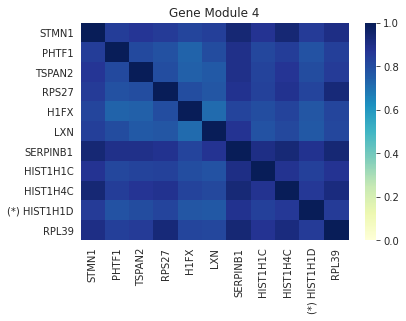

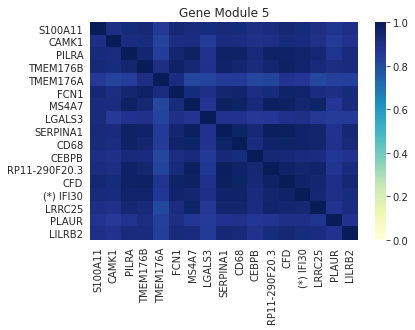

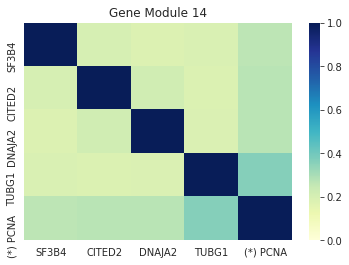

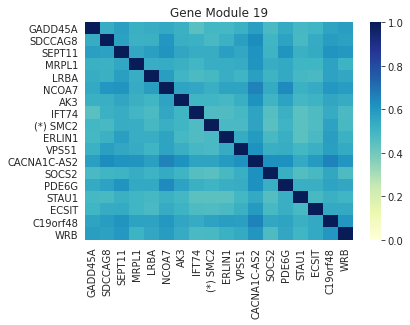

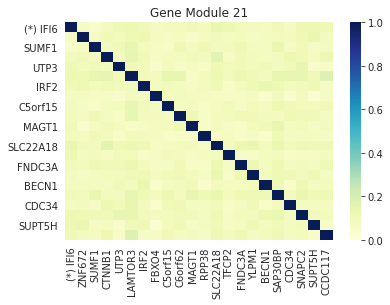

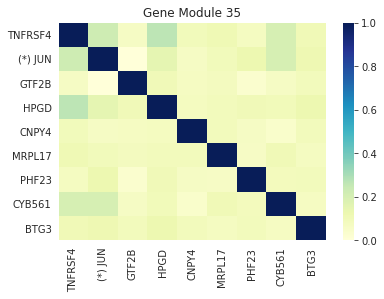

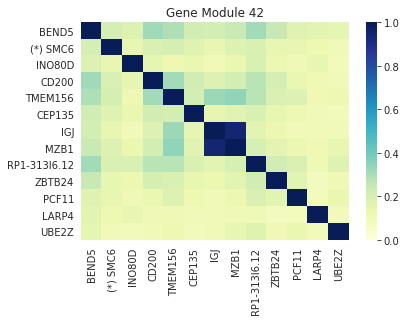

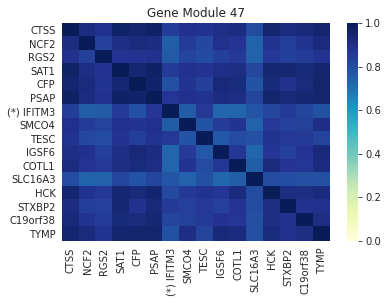

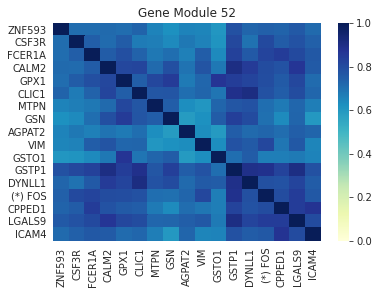

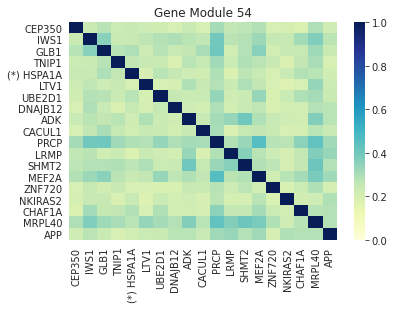

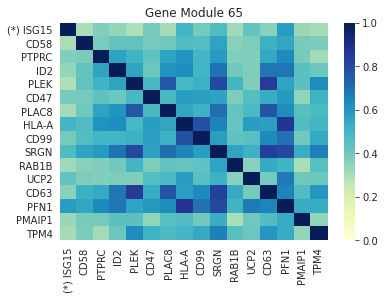

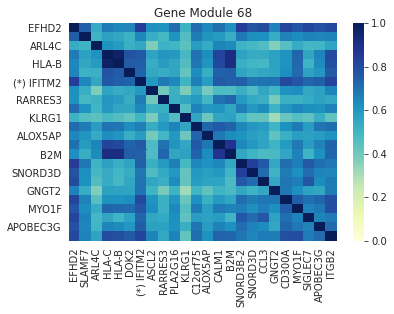

In [15]:
similarity_of_genes = mc.ut.get_vv_frame(clean, 'related_genes_similarity')
for gene_module in suspect_gene_modules:
    module_genes_mask = module_of_genes == gene_module
    similarity_of_module = similarity_of_genes.loc[module_genes_mask, module_genes_mask]
    similarity_of_module.index = \
    similarity_of_module.columns = [
        '(*) ' + name if name in suspect_gene_names else name
        for name in similarity_of_module.index
    ]
    ax = plt.axes()
    sb.heatmap(similarity_of_module, vmin=0, vmax=1, ax=ax, cmap="YlGnBu")
    ax.set_title(f'Gene Module {gene_module}')
    plt.show()

We can now extend the list of forbidden genes to include additional genes using these modules. 
Note we'd rather err on the side of caution and not forbid genes needlessly, since we expect the metacell analysis to help us expose any remaining genes we have missed. That said, thiw  will require us to regenerate the metacells with the expanded forbidden genes list.

For simplicity, we'll simply forbid all the original suspect genes as well as all the genes in the strong modules 4, 5, 47, 52 and 68. This gives us a total of 106 initially forbidden genes:

In [16]:
forbidden_genes_mask = suspect_genes_mask
for gene_module in [4, 5, 47, 52]:
    module_genes_mask = module_of_genes == gene_module
    forbidden_genes_mask |= module_genes_mask
forbidden_gene_names = sorted(clean.var_names[forbidden_genes_mask])
print(len(forbidden_gene_names))
print(' '.join(forbidden_gene_names))

106
AGPAT2 C19orf38 CALM2 CAMK1 CD68 CEBPB CFD CFP CLIC1 COTL1 CPPED1 CSF3R CTSS DYNLL1 FCER1A FCN1 FOS GPX1 GSN GSTO1 GSTP1 H1FX HCK HIST1H1C HIST1H1D HIST1H4C HSP90AB1 HSPA1A ICAM4 IFI16 IFI27 IFI27L1 IFI27L2 IFI30 IFI35 IFI44 IFI44L IFI6 IFIH1 IFIT1 IFIT1B IFIT2 IFIT3 IFIT5 IFITM1 IFITM10 IFITM2 IFITM3 IFITM5 IGSF6 ISG15 JUN LGALS3 LGALS9 LILRB2 LRRC25 LXN MCM10 MCM2 MCM3 MCM3AP MCM3AP-AS1 MCM4 MCM5 MCM6 MCM7 MCM8 MCM9 MKI67 MS4A7 MTPN NCF2 PCNA PHTF1 PILRA PLAUR PSAP RGS2 RP11-290F20.3 RPL39 RPS27 S100A11 SAT1 SERPINA1 SERPINB1 SLC16A3 SMC1A SMC1B SMC2 SMC3 SMC4 SMC5 SMC5-AS1 SMC6 SMCO4 STMN1 STXBP2 TESC TMEM176A TMEM176B TOP2A TSPAN2 TYMP VIM WARS ZNF593


## Computing the metacells

Once we have a clean data set for analysis, we can go ahead and compute the metacells.

### Main parameters

There are many parameters other than the forbidden genes list that we can tweak (see `mc.pl.divide_and_conquer_pipeline`). Here we'll just discuss controlling the main ones.

#### Reproducibility

The `random_seed` must be non-zero to ensure reprodibility. Note that even though the implementation is parallel for efficiency, the results are still reprodicible given the same random seed (in contrast to the `umap` package where you need to specify an additional flag for reproducible results).
  
#### Target Metacell size

The `target_metacell_size` (number of UMIs). We want each metacell to have a sufficient number of UMIs so that we get a robust estimation of the expression of each (relevant) gene in it. By default the target is 160,000 UMIs. The algorithm will generate metacells no larger than double this size (that is, a maximum of 320,000 UMIs per metacell) and no fewer than a quarter of this size (that is, a minimum of 40,000 UMIs per metacell), where metacells smaller than half the size (that is, between 40,000 UMIs and 80,000 UMIs) are "especially distinct". These ratios and relevant thresholds can all be controlled using additional parameters.

### Grouping into Metacells

We can finally compute the metacells. We are only running this on ~160K cells, still this may take a few minutes, depending on the number of cores on your server. For ~2 million cells this takes ~10 minutes on a 28-core server.

In [17]:
mc.pl.divide_and_conquer_pipeline(clean,
                                  forbidden_gene_names=forbidden_gene_names,
                                  #target_metacell_size=...,
                                  random_seed=123456)

/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/obk/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
set PBMC.clean.var[rare_gene_module_0]: 4 true (0.01769%) out of 22617 bools
set PBMC.clean.var[rare_gene_module_1]: 29 true (0.1282%) out of 22617 bools
set PBMC.clean.var[rare_gene]: 33 true (0.1459%) out of 22617 bools
set PBMC.clean.obs[cells_rare_gene_module]: 149102 outliers (99.52%) out of 149825 int32 elements with 2 groups with mean size 361.5
set PBMC.clean.obs[rare_cell]: 723 true (0.4826%) out of 149825 bools
/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWar

This has written many annotations for each cell (observation), the most important of which is `metacell` specifying the 0-based index of the metacell each cell belongs to (or -1 if the cell is an "outlier").

However, for further analysis, what we want is data where each observation is a metacell:

In [18]:
metacells = mc.pl.collect_metacells(clean, name='PBMC.metacells')

set PBMC.metacells.var[excluded_gene]: 0 true (0%) out of 22617 bools
set PBMC.metacells.var[clean_gene]: 22617 true (100%) out of 22617 bools
set PBMC.metacells.var[forbidden_gene]: 106 true (0.4687%) out of 22617 bools
set PBMC.metacells.var[pre_feature_gene]: 476 positive (2.105%) out of 22617 int32s
set PBMC.metacells.var[feature_gene]: 724 positive (3.201%) out of 22617 int32s
set PBMC.metacells.obs[pile]: 1546 int32s
set PBMC.metacells.obs[candidate]: 1546 int32s


### Visualizing the Metacells

A common technique is to use UMAP to project the metacells to a 2D scatter plot. The code provides built-in support for generating such projections. UMAP offers many parameters that can be tweaked, but the main one we offer control over is `min_dist` which controls how tightly the points are packed together. A non-zero `random_seed` will make this computation reproducible, at the cost of switching to a single-threaded implementation.

In [19]:
mc.pl.compute_umap_by_features(metacells, max_top_feature_genes=1000,
                               min_dist=2.0, random_seed=123456)

set PBMC.metacells.var[top_feature_gene]: 724 true (3.201%) out of 22617 bools
set PBMC.metacells.obsp[obs_balanced_ranks]: 14468 nonzero (0.6053%) out of 2390116 elements
set PBMC.metacells.obsp[obs_pruned_ranks]: 5500 nonzero (0.2301%) out of 2390116 elements
set PBMC.metacells.obsp[obs_outgoing_weights]: 5500 nonzero (0.2301%) out of 2390116 elements
/home/obk/.local/lib/python3.7/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/obk/.local/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
set PBMC.metacells.obs[umap_x]: 1546 float32s
set PBMC.metacells.obs[umap_y]: 1546 float32s


This filled in `umap_x` and `umap_y` per-metacell (observation) annotations, which can be used to generate 2D projection diagrams (it also filled in a boolean `top_feature_gene` mask designating the genes used). Typically such diagrams use additional metadata (such as type annotations) to color the points, but here we just show the raw projection:

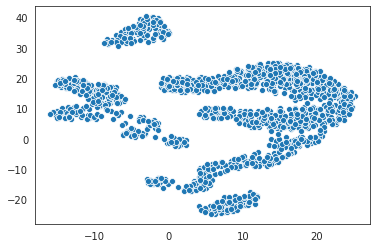

In [20]:
umap_x = mc.ut.get_o_numpy(metacells, 'umap_x')
umap_y = mc.ut.get_o_numpy(metacells, 'umap_y')
plot = sb.scatterplot(x=umap_x, y=umap_y)

We can also visualize the (skeleton) KNN graph on top of the UMAP. Long edges indicate that UMAP did not capture this skeleton KNN graph well. This must be inevitable due to the need to project a complex N-dimentional structure to 2D, or it might indicate that we are using some as features some "lateral" genes which are not relevant to the structure we are investigating. To make this clearer we can just filter out the short edges:

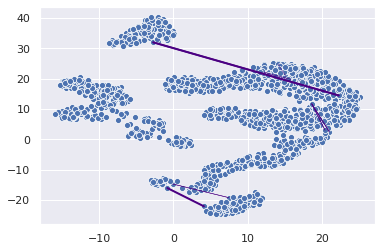

In [21]:
umap_edges = sp.coo_matrix(mc.ut.get_oo_proper(metacells, 'obs_outgoing_weights'))
min_long_edge_size = 4
sb.set()
plot = sb.scatterplot(x=umap_x, y=umap_y)
for (source_index, target_index, weight) \
        in zip(umap_edges.row, umap_edges.col, umap_edges.data):
    source_x = umap_x[source_index]
    target_x = umap_x[target_index]
    source_y = umap_y[source_index]
    target_y = umap_y[target_index]
    if hypot(target_x - source_x, target_y - source_y) >= min_long_edge_size:
        plt.plot([source_x, target_x], [source_y, target_y],
                 linewidth=weight * 2, color='indigo')
plt.show()

## Further analysis

Metacells is **not** an scRNA analysis method. Rather, it is meant to be an (early) step in the analysis process. The promise of metacells is that it makes further analysis easier; instead of grappling with many individual cells with a very weak and noisy signal of few hundred UMIs in each, one can analyze fewer complete metacells with a strong signal of tens of thousands of UMIs, which allows for robust estimation of their gene expression levels. Therefore, working on metacells instead of single cells makes life easier for any further analysis method one wishes to use.

Further analysis methods are expected to create variable-sized groups of metacells with a similar "cell type" or gradients of metacells between such "cell types", based on the gene programs they express. Such methods are beyond the scope of the metacells package; it merely prepares the input for such methods and is agnostic to the exact method of further analysis.

In particular, "metacells of metacells" is *not* a good method: An "ideal" metacell is defined "a group of cells, with a maximal size, with the same biological state". Crucially, this maximal size is picked to be the smallest that allows for robust estimation of gene expression in the metacell; this allows for capturing rare behaviors in their own metacells, instead of them becoming outliers.

Computing "metacells of metacells" would suffer from the same problem as having a too-large target metacell size: it would artifically quantize gradients into less intermediate states, and it would identify rare behavior metacells as outliers. At the same time, computing metacells-of-metacells can not be trusted to group all the metacells of the "same" (or very similar) cell state together, since the grouping will obey some (artificial) maximal size limit.

Thus, the best thing we can do now is to save the data, and feed it to a separate further data analysis pipeline. To import the data into Seurat, we first need to delete the special `__name__` property, since for some reason it breaks the Seurat importer.

The [manual analysis vignette](Manual_Analysis.html) demonstrates manual analysis of the data (based on the [MCView](https://tanaylab.github.io/MCView) tool), and the [seurat analysis vignette](Seurat_Analysis.html) demonstrates importing the metacells into [Seurat](https://satijalab.org/seurat/index.html) for further analysis there.

In [22]:
clean.write('cells.h5ad')
metacells.write('metacells.h5ad')
del metacells.uns['__name__']
metacells.write('for_seurat.h5ad')

/home/obk/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
